In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.print_utils import *
from utils.model_utils import *
from utils.interpol_utils import *
from utils.optimization_utils import *
from utils.data_utils import *
from utils.filters_utils import *
from utils.rbf import *
import pysindy as ps 
import numpy as np
from scipy.ndimage import gaussian_filter

In [2]:
timesteps = 100
# Parameters
K = 105  # Strike price
r = 0.1 # Risk-free interest rate
sigma = 0.4  # Volatility
S = np.linspace(0.1, 3*K, timesteps)  # Stock price
T = np.linspace(0., 1, timesteps)  # Time to maturity

h_S = S[1] - S[0]  # step size for S
h_T = T[1] - T[0]  # step size for T

# Create a meshgrid for S and T
SS, TT = np.meshgrid(S, T)
ST = np.asarray([SS, TT]).T

# Calculate the call prices and the deltas and gammas for the grid
call_prices = black_scholes(SS, K, TT, r, sigma)
theta = black_scholes_theta(SS, K, TT, r, sigma).T[:,1:]
deltas = black_scholes_delta(SS, K, TT, r, sigma)
gammas = black_scholes_gamma(SS, K, TT, r, sigma)

d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:93: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:76: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:78: RuntimeWarning: invalid value encountered in divide
  theta = -sigma * S * norm.pdf(d1) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:83: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:88: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d:\FACULDADE\bs-find-with-sindy\src\utils\data_ut

In [3]:


subsampled_u,subsampled_x,random_rows = subsample_f(call_prices,T,S,timesteps)

# Sample data points and values
X = np.array([list(a) for a in zip(subsampled_x,T)])

subsampled_u_x = np.ravel(deltas[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
subsampled_u_xx = np.ravel(gammas[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])



# Subsample the grid to create a less dense grid for interpolation
indices = np.random.choice(np.arange(len(S) * len(T)), size=int(len(T)), replace=True)
sub_SS = SS.flatten()[indices]
sub_TT = TT.flatten()[indices]
sub_X = np.array([list(a) for a in zip(sub_SS,sub_TT)])
sub_call_prices = call_prices.flatten()[indices]



In [42]:

def RBFN_2d(X, Y, rbf_class, epsilon=1e-6):
    n = Y.shape[0]

    # Compute the distance matrix between all pairs of center points
    dist_matrix = cdist(X, X)

    # Add epsilon to the diagonal for numerical stability
    np.fill_diagonal(dist_matrix, dist_matrix.diagonal() + epsilon)

    # Compute the RBF matrix
    RBF_matrix = rbf_class.eval_func(dist_matrix)

    # Solve for the coefficients using linear least squares
    coefficients, _, _, _ = np.linalg.lstsq(RBF_matrix, Y)

    def compute_at_point(x, y):
        x_grid, y_grid = np.meshgrid(x, y)
        grid_points = np.column_stack((x_grid.ravel(), y_grid.ravel()))
        m = grid_points.shape[0]
        interpolated_values = np.zeros(m)
        interpolated_values_x = np.zeros(m)
        interpolated_values_xx = np.zeros(m)
        interpolated_values_y = np.zeros(m)

        for i in range(m):
            # Compute distances from the current grid point to all centers
            distances = X - grid_points[i]
            distances[distances == 0] = epsilon
            # Evaluate the radial basis function for these distances
            g_i = rbf_class.eval_func(np.linalg.norm(distances,axis=1))
            interpolated_values[i] = np.dot(coefficients, g_i)

            # Compute first and second derivatives for x
            h_i_x = rbf_class.eval_func_derivative_2d(np.atleast_2d(distances), axis=1)
            H_i_xx = rbf_class.eval_func_2_derivative_2d(np.atleast_2d(distances), axis=1)
            interpolated_values_x[i] = np.dot(coefficients, h_i_x)
            interpolated_values_xx[i] = np.dot(coefficients, H_i_xx)

            # Compute first and second derivatives for y
            h_i_y = rbf_class.eval_func_derivative_2d(np.atleast_2d(distances), axis=2)
            if grid_points[i,1] != 0:
                interpolated_values_y[i] = np.dot(coefficients, h_i_y)
            # interpolated_values_yy[i] = np.dot(coefficients, H_i_yy)  # If needed

        return interpolated_values, interpolated_values_x, interpolated_values_xx, interpolated_values_y, coefficients

    return compute_at_point

In [45]:
# Interpolate the surface
rbf_values,rbf_values_x,rbf_values_xx,rbf_values_t,_  = RBFN_2d(sub_X, sub_call_prices,cubic_rbf())(S,T)

# Perform RBF interpolation on the original grid
rbf_call_prices = rbf_interpolation_on_grid(sub_SS, sub_TT, sub_call_prices, SS, TT)
# rbf_call_prices = gaussian_filter(rbf_call_prices,sigma=1)
# Compute the numerical derivatives of the RBF interpolated surface
# First derivatives
rbf_deltas_numerical = numerical_derivative(rbf_call_prices, axis=0, h=h_S)
rbf_theta_numerical = numerical_derivative(rbf_call_prices, axis=1, h=h_T)

# Second derivatives
rbf_gamma_numerical = numerical_second_derivative(rbf_call_prices, axis=0, h=h_S)

C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_27544\3306290049.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefficients, _, _, _ = np.linalg.lstsq(RBF_matrix, Y)


Error for RBF-smooth derivation
0.00016845707477779526
Error for rbf derivation
3.402988661223604e-05


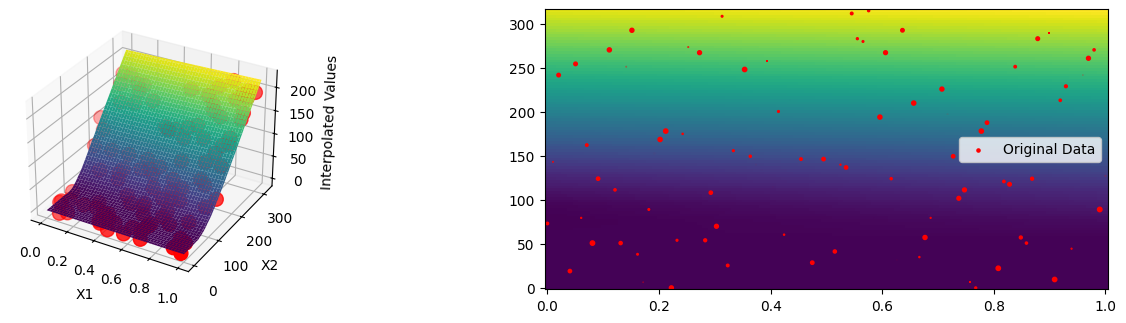

In [34]:
# Plot the interpolated surface
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(TT, SS, rbf_values.reshape(SS.shape), cmap='viridis')

# Plot the original data points
ax.scatter(sub_TT,sub_SS, sub_call_prices, c='red', s=100, label='Original Data')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Interpolated Values')

ax2 = fig.add_subplot(222)
ax2.pcolormesh(T,S,  rbf_values.reshape(SS.shape).T)
ax2.scatter(X[:, 1], X[:, 0] , s=sub_call_prices/20, c='red', label='Original Data')
ax2 = plt.gca()

# ax3 = fig.add_subplot(223)
# ax3.pcolormesh(T, S, call_prices.T)
# ax3= plt.gca()


# ax4 = fig.add_subplot(224)
# ax4.pcolormesh(T, S, rbf_cal.T)
# ax4= plt.gca()

print('Error for RBF-smooth derivation')
print(relative_squared_error(rbf_call_prices.flatten(),call_prices.flatten()))
print('Error for rbf derivation')
print(relative_squared_error(rbf_values,call_prices.flatten()))


plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error for RBF-smooth derivation
0.7676484565106935
Error for rbf derivation
0.05200323340332627


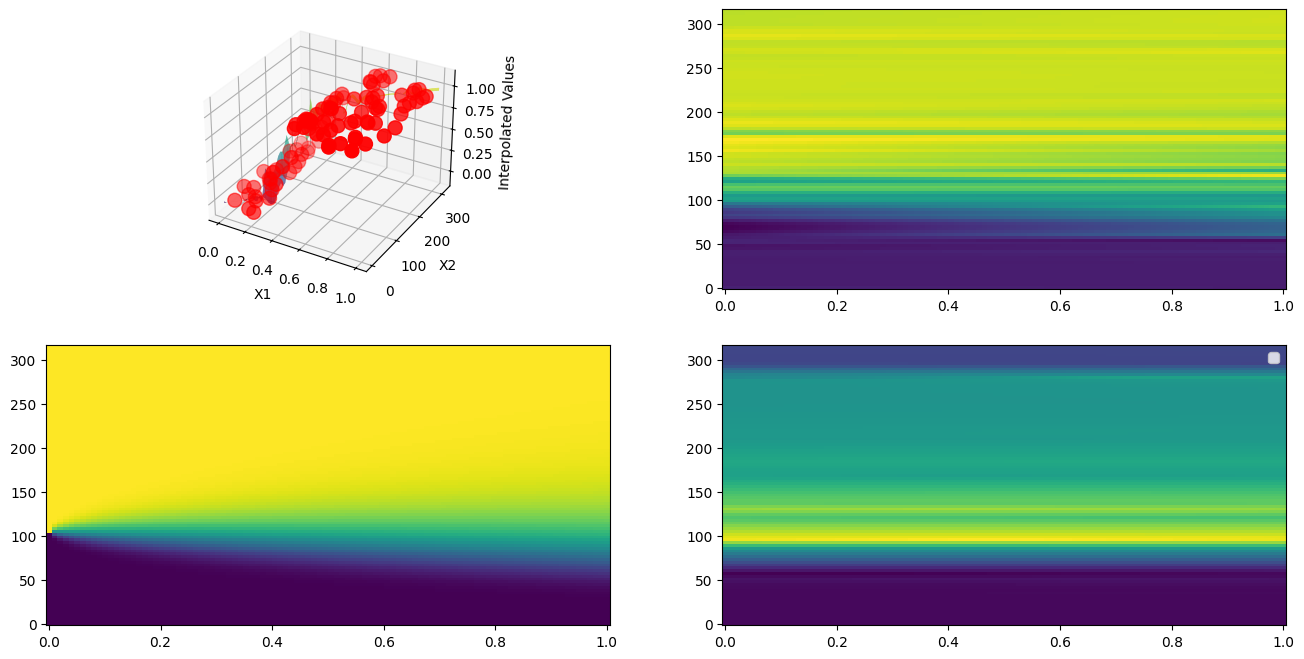

In [35]:
# numerical_derivative_interpolated = ps.FiniteDifference(axis=0,order = 2)._differentiate(rbf_values,t = np.ravel(S))

# Plot the interpolated surface
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(T, S, rbf_values_x.reshape(SS.shape), cmap='viridis')

# Plot the original data points
ax.scatter(X[:, 1], X[:, 0], subsampled_u_x, c='red', s=100, label='Original Data')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Interpolated Values')


ax2 = fig.add_subplot(222)
ax2.pcolormesh(T, S,  rbf_values_x.reshape(SS.shape).T)
ax2 = plt.gca()

ax3 = fig.add_subplot(223)
ax3.pcolormesh(T, S, deltas.T)
ax3= plt.gca()

ax4 = fig.add_subplot(224)
ax4.pcolormesh(T, S, rbf_deltas_numerical.T)
ax4 = plt.gca()

print('Error for RBF-smooth derivation')
print(root_mean_squared_error(rbf_deltas_numerical.flatten(),deltas.flatten()))
print('Error for rbf derivation')
print(root_mean_squared_error(rbf_values_x,deltas.flatten()))
plt.legend()
plt.show()




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error for RBF-smooth derivation
3.8073748713270597
Error for rbf derivation
15.739453682254132


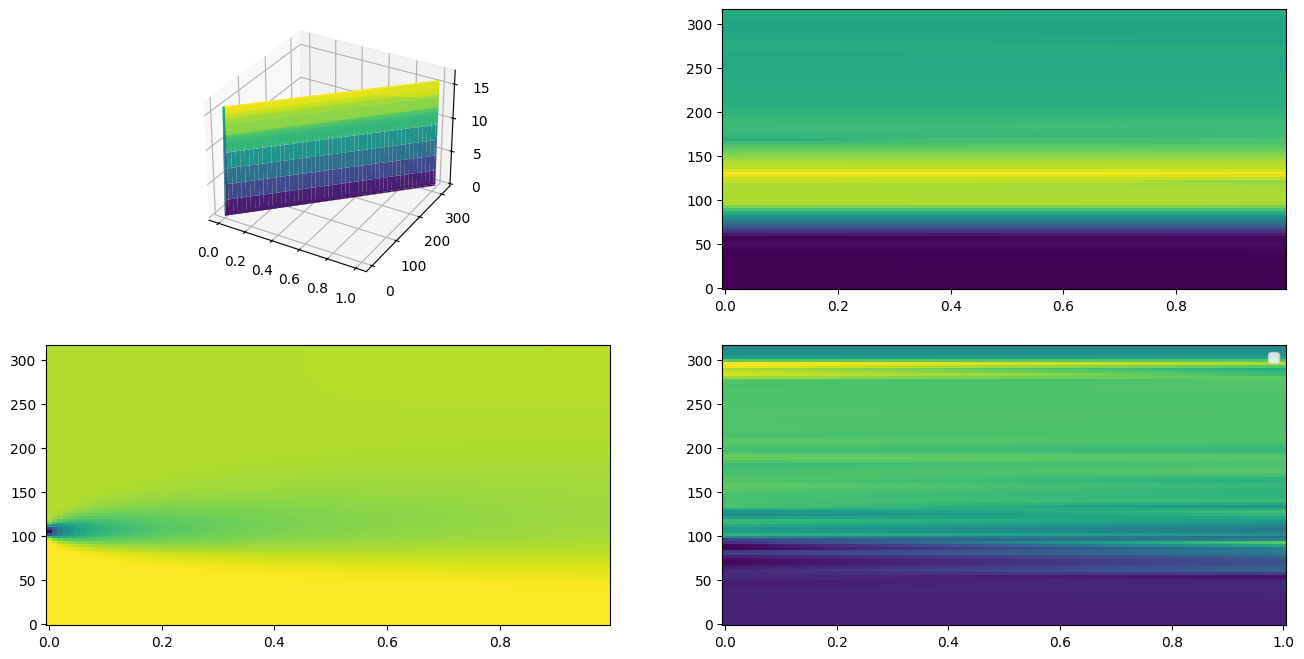

In [59]:
# Plot the interpolated surface
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(T, S, rbf_values_t.reshape(SS.shape).T, cmap='viridis')



ax2 = fig.add_subplot(222)
ax2.pcolormesh(T[:-1], S,  rbf_values_t.reshape(SS.shape).T[:,1:])
ax2 = plt.gca()

ax3 = fig.add_subplot(223)
ax3.pcolormesh(T[:-1], S, theta)
ax3= plt.gca()

ax4 = fig.add_subplot(224)
ax4.pcolormesh(T, S, rbf_theta_numerical.T)
ax4 = plt.gca() 

print('Error for RBF-smooth derivation')
print(relative_squared_error(rbf_theta_numerical.flatten()[100:],theta.flatten()))
print('Error for rbf derivation')
print(relative_squared_error(rbf_values_t[100:],theta.flatten()))
plt.legend()
plt.show()




C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_27544\3306290049.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefficients, _, _, _ = np.linalg.lstsq(RBF_matrix, Y)


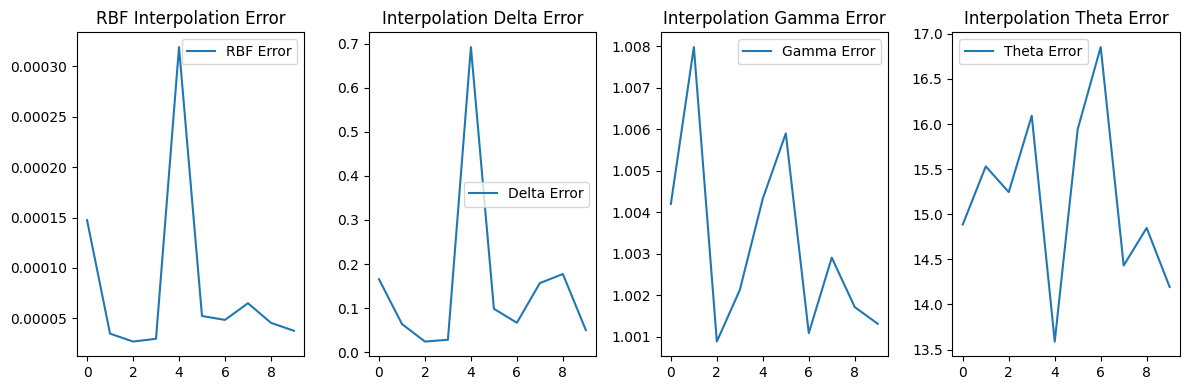

In [61]:
import numpy as np
import matplotlib.pyplot as plt

num_runs = 10
errors_rbf = []
errors_delta = []
errors_gamma = []
errors_theta = []

for _ in range(num_runs):
    subsampled_u, subsampled_x, random_rows = subsample_f(call_prices, T, S, timesteps)
    X = np.array([list(a) for a in zip(subsampled_x, T)])
    subsampled_u_x = np.ravel(deltas[random_rows, np.linspace(0, timesteps - 1, timesteps, dtype=int)])
    subsampled_u_xx = np.ravel(gammas[random_rows, np.linspace(0, timesteps - 1, timesteps, dtype=int)])

    indices = np.random.choice(np.arange(len(S) * len(T)), size=int(len(T)), replace=True)
    sub_SS = SS.flatten()[indices]
    sub_TT = TT.flatten()[indices]
    sub_X = np.array([list(a) for a in zip(sub_SS, sub_TT)])
    sub_call_prices = call_prices.flatten()[indices]

    rbf_values,rbf_values_x,rbf_values_xx,rbf_values_t,_ = RBFN_2d(sub_X, sub_call_prices,cubic_rbf())(S,T)
    
    rbf_deltas_numerical = numerical_derivative(rbf_values.reshape(100,100), axis=0, h=h_S)
    rbf_theta_numerical = numerical_derivative(rbf_values.reshape(100,100), axis=1, h=h_T)

    # Second derivatives
    rbf_gamma_numerical = numerical_second_derivative(rbf_values.reshape(100,100), axis=0, h=h_S)

    # Calculate errors
    error_rbf = relative_squared_error(call_prices.flatten(), rbf_values) 
    error_delta = relative_squared_error(deltas.flatten(),rbf_values_x)
    error_gamma = relative_squared_error(rbf_values_xx[100:],gammas[1:].flatten())
    error_theta = relative_squared_error(rbf_values_t[100:],theta.flatten())

    errors_rbf.append(error_rbf)
    errors_delta.append(error_delta)
    errors_gamma.append(error_gamma)
    errors_theta.append(error_theta)



# Plot errors
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.plot(errors_rbf, label='RBF Error')
plt.title('RBF Interpolation Error')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(errors_delta, label='Delta Error')
# plt.plot(errors_delta_n, label='Delta Numerical Error')
plt.title('Interpolation Delta Error')

plt.legend()

plt.subplot(1, 4, 3)
plt.plot(errors_gamma, label='Gamma Error')
# plt.plot(errors_gamma_n, label='Gamma Numerical Error')
plt.title('Interpolation Gamma Error')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(errors_theta, label='Theta Error')
# plt.plot(errors_theta_n, label='Theta Numerical Error')

plt.title('Interpolation Theta Error')
plt.legend()

plt.tight_layout()
plt.show()


In [91]:
Theta = np.array([sub_SS.flatten(),sub_SS.flatten()**2,rbf_values.flatten()[indices],rbf_values_x.flatten()[indices],rbf_values_xx.flatten()[indices]]).T

Crossed_Theta,Theta_names = build_cross_library(Theta,['x','x^2','u','u_x','u_xx'])

optimizer = ps.STLSQ(threshold=1e-2, alpha=1e2).fit(Crossed_Theta,rbf_values_t.flatten()[indices])

print_model(optimizer.coef_[0],Theta_names,precision=5)

new_coef = threshold_remove(Crossed_Theta,optimizer.coef_[0],rbf_values_t.flatten()[indices],threshold=0.01)

print_model(new_coef,Theta_names,precision=5)


u_t = + 0.08074 x + 0.05236 u + 0.04475 u_x + 0.08675 x*u_x + -0.2717 u*u_x + -0.21904 u_x*u_xx
u_t = + 0.07985 x + 0.06205 u + 0.08874 x*u_x + -0.28337 u*u_x


In [98]:
num_ensembles = 300  # This is the number of models in the ensemble
subset_size = len(rbf_theta_numerical.flatten()[indices]) // 2  # Example subset size
# np.random.seed(32)
opt = ps.STLSQ(threshold=1e-2, alpha=1e3)

ensemble_models = []
for _ in range(num_ensembles):
    # Create a bootstrap sample or random subsample of your data
    idx = np.random.choice(len(rbf_theta_numerical), size=subset_size)
    subsample_SS = SS.flatten()[indices][idx]
    subsample_rbf_call_prices = rbf_values.flatten()[indices][idx]
    subsample_rbf_call_prices = rbf_values_x.flatten()[indices][idx]
    subsample_rbf_call_prices = rbf_values_xx.flatten()[indices][idx]


    # Build the library for this subsample
    Theta_subsample = np.array([
        subsample_SS,
        subsample_SS**2,
        subsample_rbf_call_prices,
        subsample_rbf_call_prices,
        subsample_rbf_call_prices
    ]).T
    
    Crossed_Theta_subsample, Theta_names = build_cross_library(
        Theta_subsample,
        ['x', 'x^2', 'u', 'u_x', 'u_xx']
    )   
    # Step 2: Train Individual Model
    opt_ = opt.fit(
        Crossed_Theta_subsample, 
        rbf_values_t.flatten()[indices][idx]
    )
    ensemble_models.append(opt_)

# Step 3: Aggregate Models
# For example, by averaging the coefficients
average_coefs = np.median([model.coef_ for model in ensemble_models], axis=0)

# Print the ensemble model
print_model(average_coefs[0], Theta_names, precision=5)


u_t = + 0.05779 x + 0.06649 u*u_x + 0.06649 u*u_xx + 0.06649 u_x*u_xx


In [ ]:
num_ensembles = 10  # This is the number of models in the ensemble
data_subset_size = len(rbf_theta_numerical) // 2  # Example subset size for data points
feature_subset_size = 6  # Example subset size for features, assuming you have more than 3 features
opt = ps.STLSQ(threshold=1e-2, alpha=1e3)


ensemble_models = []
for _ in range(num_ensembles):
    # Create a random subsample of your data points
    data_indices = np.random.choice(len(rbf_values_t), size=data_subset_size, replace=False)
    # Select the subsample of the Theta matrix corresponding to the chosen data points and features
    Theta_subsample = Theta[data_indices]
    # If using crossed terms, you need to build the library only with the selected features
    Crossed_Theta_subsample, Theta_names_subsample = build_cross_library(
        Theta_subsample,
        # You need to pass the corresponding names of the selected features
        Theta_names
    )
    # Create a random subsample of your features
    feature_indices = np.random.choice(Crossed_Theta_subsample.shape[1], size=feature_subset_size, replace=False)

    Crossed_Theta_subsample_feature = Crossed_Theta_subsample[:,feature_indices]

    opt_ = opt.fit(
        Crossed_Theta_subsample_feature, 
        rbf_theta_numerical.flatten()[data_indices]
    )
    ensemble_models.append(opt_)

# Step 3: Aggregate Models
# For example, by averaging the coefficients. Note that you may need to handle averaging differently since
# not all models will use the same features.
# This is a simple averaging, assuming all models have coefficients in the same order.
average_coefs = np.median([model.coef_ for model in ensemble_models], axis=0)

# Print the ensemble model
print_model(average_coefs[0], Theta_names, precision=5)


u_t = + -1.7913 x + -0.39454 x^2 + -0.01559 u + 4.03305 u_x + 0.01544 u_xx + 1.33331 x*x^2
